# Import Libraries

In [1]:
!nvidia-smi

Wed Apr  9 15:20:24 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.30                 Driver Version: 546.30       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0              26W /  87W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import json
import pickle
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate

Setting up device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Loading Dataset

In [4]:
data_path = 'dataset/synthetic_dataset.json'

with open(data_path, 'r', encoding='utf-8') as file:
    train_data = json.load(file)

texts = [d['text'] for d in train_data]
labels = [d['label'] for d in train_data]

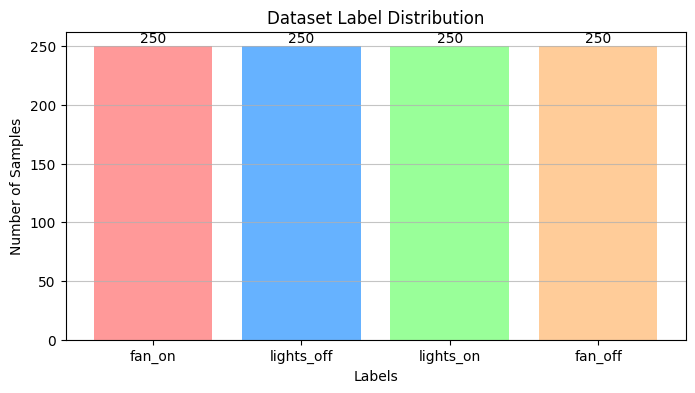

In [5]:
# Extract labels
labels = [item['label'] for item in train_data]

# Count occurrences of each label
label_counts = Counter(labels)

# Prepare data for plotting
label_names = list(label_counts.keys())
label_values = list(label_counts.values())

# Create bar plot
plt.figure(figsize=(8, 4))
plt.bar(label_names, label_values, color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Dataset Label Distribution')
plt.grid(axis='y', alpha=0.75)

# Add value labels on top of each bar
for i, v in enumerate(label_values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

Spliting dataset to train and test.

In [6]:
# Convert labels to numerical values
label_map = {"lights_on": 0, "lights_off": 1, "fan_on": 2, "fan_off": 3}
y = [label_map[label] for label in labels]

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=50)
X = vectorizer.fit_transform(texts).toarray()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Distribution of train and test set.

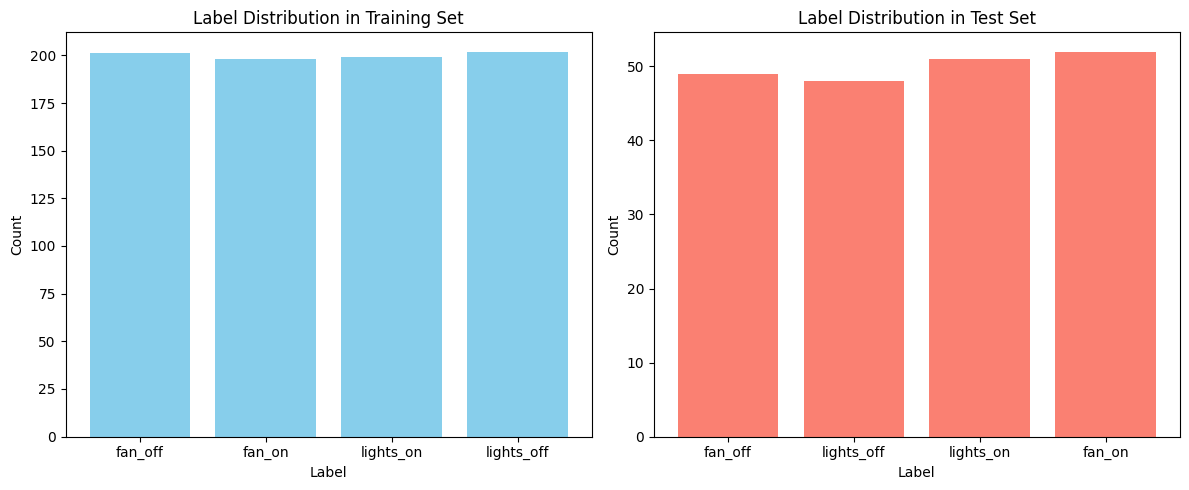

In [7]:
# Count label occurrences
train_counter = Counter(y_train)
test_counter = Counter(y_test)

# Map label indices back to names for readability
inverse_label_map = {v: k for k, v in label_map.items()}

# Convert counts to label names
train_labels = [inverse_label_map[i] for i in train_counter.keys()]
test_labels = [inverse_label_map[i] for i in test_counter.keys()]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train set distribution
axes[0].bar(train_labels, train_counter.values(), color='skyblue')
axes[0].set_title('Label Distribution in Training Set')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Test set distribution
axes[1].bar(test_labels, test_counter.values(), color='salmon')
axes[1].set_title('Label Distribution in Test Set')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## Dataset Module

In [8]:
# Custom Dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Model

In [9]:
# Neural Network Model
class TextClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TextClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# Training

## Hyperparameters

In [10]:
# Hyperparameters
input_size = X.shape[1]  # Number of TF-IDF features
hidden_size = 20
num_classes = 4
learning_rate = 0.01
num_epochs = 200
batch_size = 10

In [11]:
print(f'Using device: {device}')

Using device: cuda


## Loading Dataset

In [12]:
# Datasets and Loaders
train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, y_test), batch_size=batch_size)

## Initialize Model and Training

In [13]:
# Model, loss, optimizer
model = TextClassifier(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# Accuracy function
def evaluate_accuracy(loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total

In [15]:
# Training
train_losses = []

print(f"{'Epoch':<10} {'Train Loss':<15} {'Test Accuracy':<15}")
print("=" * 40)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 20 == 0 or epoch == num_epochs - 1:
        acc = evaluate_accuracy(test_loader)
        print(f"{epoch+1:<10} {avg_loss:<15.4f} {acc*100:<15.2f}")

Epoch      Train Loss      Test Accuracy  
20         0.0003          100.00         
40         0.0001          100.00         
60         0.0000          100.00         
80         0.0000          100.00         
100        0.0000          100.00         
120        0.0000          100.00         
140        0.0000          100.00         
160        0.0000          100.00         
180        0.0000          100.00         
200        0.0000          100.00         


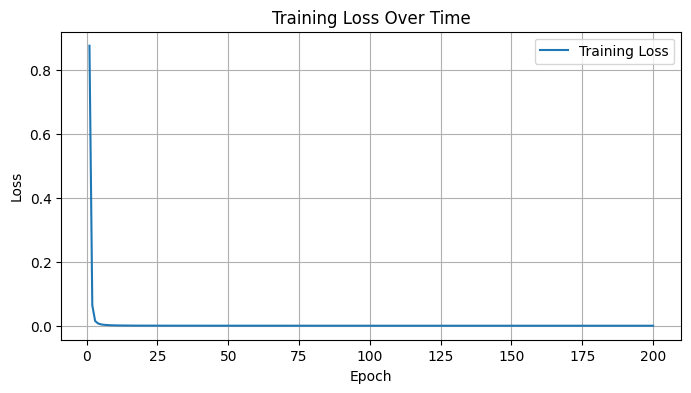

In [16]:
# Plotting the training loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

In [17]:
# Evaluation
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Test the model
accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 100.00%


# Inference

In [18]:
# Function to predict new text
def predict_text(text, model, vectorizer):
    model.eval()
    # Transform new text using the same vectorizer
    text_vector = vectorizer.transform([text]).toarray()
    text_tensor = torch.FloatTensor(text_vector).to(device)
    
    with torch.no_grad():
        output = model(text_tensor)
        _, predicted = torch.max(output, 1)
    
    reverse_map = {0: "lights_on", 1: "lights_off", 2: "fan_on", 3: "fan_off"}
    return reverse_map[predicted.item()]

# Example prediction
new_text = "fan on"
prediction = predict_text(new_text, model, vectorizer)
print(f'Prediction for "{new_text}": {prediction}')

Prediction for "fan on": fan_on


## Saving Model

In [19]:
def save_model(model, vectorizer, path="model/text_classifier_model"):
    # Create a dictionary with state dict and architecture parameters
    save_dict = {
        'state_dict': model.state_dict(),
        'input_size': model.layer1.in_features,
        'hidden_size': model.layer1.out_features,
        'num_classes': model.layer2.out_features
    }
    
    # Save the model dictionary
    torch.save(save_dict, f"{path}.pth")
    
    with open(f"{path}_vectorizer.pkl", 'wb') as f:
        pickle.dump(vectorizer, f)
    
    print(f"✅ Model saved to '{path}.pth'")
    print(f"✅ Vectorizer saved to '{path}_vectorizer.pkl'")

# Save the model after training
model_name = 'model/TextClassifier'
save_model(model, vectorizer, model_name)

✅ Model saved to 'model/TextClassifier.pth'
✅ Vectorizer saved to 'model/TextClassifier_vectorizer.pkl'


# Loading Model and Inference

In [20]:
def load_model(model_class, model_path="model/TextClassifier.pth", vectorizer_path="model/TextClassifier_vectorizer.pkl"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    saved_data = torch.load(model_path, map_location=device, weights_only=False)

    input_size = saved_data['input_size']
    hidden_size = saved_data['hidden_size']
    num_classes = saved_data['num_classes']

    loaded_model = model_class(input_size, hidden_size, num_classes).to(device)
    loaded_model.load_state_dict(saved_data['state_dict'])
    loaded_model.eval()

    with open(vectorizer_path, 'rb') as f:
        loaded_vectorizer = pickle.load(f)

    print("✅ Model and vectorizer loaded successfully.")
    return loaded_model, loaded_vectorizer, device

In [21]:
# Example of how to use the loaded model
def predict_with_loaded_model(text, model, vectorizer, device):
    model.eval()
    text_vector = vectorizer.transform([text]).toarray()
    text_tensor = torch.FloatTensor(text_vector).to(device)
    
    with torch.no_grad():
        output = model(text_tensor)
        _, predicted = torch.max(output, 1)
    
    reverse_map = {0: "lights_on", 1: "lights_off", 2: "fan_on", 3: "fan_off"}
    return reverse_map[predicted.item()]

## Inference with loaded model

In [22]:
# After training and saving, you can later load it like this:
loaded_model, loaded_vectorizer, device = load_model(TextClassifier)

test_samples = [
    # fan_on
    {"text": "can you turn the fan on", "label": "fan_on"},
    {"text": "fan needs to be running", "label": "fan_on"},
    {"text": "I want the fan on now", "label": "fan_on"},
    
    # fan_off
    {"text": "kill the fan", "label": "fan_off"},
    {"text": "turn that fan off", "label": "fan_off"},
    {"text": "yo shut off the fan", "label": "fan_off"},
    
    # lights_on
    {"text": "let there be light", "label": "lights_on"},
    {"text": "I can't see, lights on", "label": "lights_on"},
    {"text": "please switch the lights on", "label": "lights_on"},
    
    # lights_off
    {"text": "it's too bright, turn off the lights", "label": "lights_off"},
    {"text": "kill the lights", "label": "lights_off"},
    {"text": "I’m going to sleep, lights off", "label": "lights_off"},
]

results = []

for sample in test_samples:
    text = sample['text']
    label = sample['label']

    prediction = predict_with_loaded_model(text, loaded_model, loaded_vectorizer, device)

    match = "✅" if prediction == label else "❌"
    results.append([text, label, prediction, match])

✅ Model and vectorizer loaded successfully.


In [23]:
# Print as a table
headers = ["Text", "True Label", "Predicted Label", "Match"]
print(tabulate(results, headers=headers, tablefmt="simple"))

Text                                  True Label    Predicted Label    Match
------------------------------------  ------------  -----------------  -------
can you turn the fan on               fan_on        fan_on             ✅
fan needs to be running               fan_on        fan_off            ❌
I want the fan on now                 fan_on        fan_on             ✅
kill the fan                          fan_off       fan_off            ✅
turn that fan off                     fan_off       fan_off            ✅
yo shut off the fan                   fan_off       fan_off            ✅
let there be light                    lights_on     lights_on          ✅
I can't see, lights on                lights_on     lights_on          ✅
please switch the lights on           lights_on     lights_on          ✅
it's too bright, turn off the lights  lights_off    lights_off         ✅
kill the lights                       lights_off    lights_off         ✅
I’m going to sleep, lights off        lig